# Виявлення викидів та аномалій

## 1. Вступ до виявлення викидів та аномалій

### Що таке викиди?

**Викид** - це точка даних, яка значно відрізняється від інших спостережень у наборі даних. Викиди можуть бути:

- **Точкові викиди**: Окремі точки даних, які є аномальними
- **Контекстні викиди**: Нормальні в одному контексті, але аномальні в іншому
- **Колективні викиди**: Колекція точок даних, які є аномальними як група

### Викиди vs Шум

Важливо розрізняти викиди та шум:

| **Викиди** | **Шум** |
|------------|---------|
| Значущі відхилення від патерну | Випадкові помилки або неточності вимірювання |
| Можуть містити цінну інформацію | Слід видалити або виправити |
| Можуть вказувати на шахрайство, помилки або рідкісні події | Затуляє справжній сигнал |
| Варто дослідити | Варто відфільтрувати |

### Навіщо виявляти викиди?

1. **Якість даних**: Ідентифікувати помилки в зборі даних
2. **Безпека**: Виявляти шахрайські дії
3. **Моніторинг систем**: Ідентифікувати відмови обладнання або незвичайну поведінку
4. **Наукові відкриття**: Знаходити рідкісні явища або нові патерни
5. **Якість моделі**: Покращити точність моделей машинного навчання

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


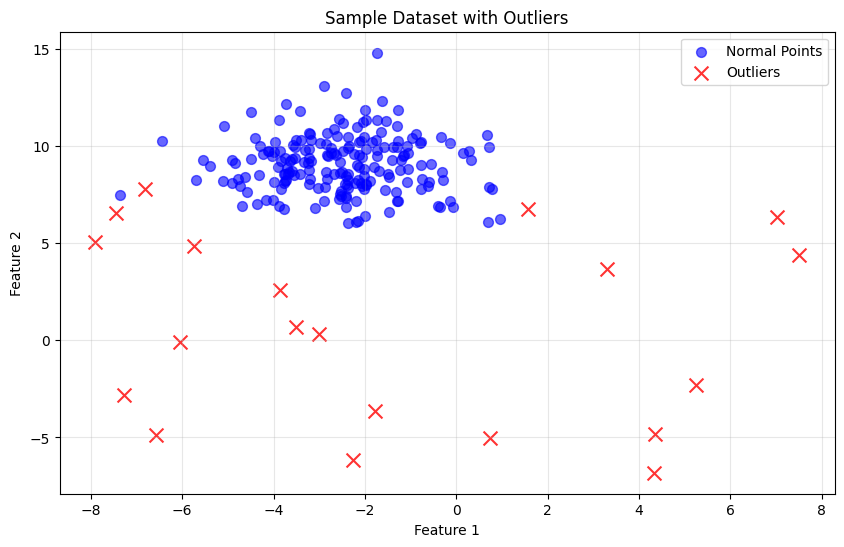

Dataset shape: (220, 2)
Number of normal points: 200
Number of outliers: 20


In [4]:
# Create a synthetic dataset with outliers for demonstration
def create_sample_data():
    """Create a dataset with normal points and outliers"""
    # Generate normal data points
    normal_data, _ = make_blobs(n_samples=200, centers=1, cluster_std=1.5, random_state=42)
    
    # Generate outliers
    outliers = np.random.uniform(-8, 8, (20, 2))
    
    # Combine data
    X = np.vstack([normal_data, outliers])
    y = np.hstack([np.zeros(200), np.ones(20)])  # 0 = normal, 1 = outlier
    
    return X, y

# Create and visualize the dataset
X, y = create_sample_data()

plt.figure(figsize=(10, 6))
plt.scatter(X[y==0, 0], X[y==0, 1], c='blue', alpha=0.6, label='Normal Points', s=50)
plt.scatter(X[y==1, 0], X[y==1, 1], c='red', alpha=0.8, label='Outliers', s=100, marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Sample Dataset with Outliers')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Dataset shape: {X.shape}")
print(f"Number of normal points: {np.sum(y==0)}")
print(f"Number of outliers: {np.sum(y==1)}")


## 2. Статистичні методи

Статистичні методи - найпростіші та найінтуїтивніші підходи до виявлення викидів. Вони добре працюють для одновимірних даних та припускають, що дані слідують нормальному розподілу.

### Z-статистика (Z-score)

**Z-статистика** вимірює, на яку кількість стандартних відхилень точка даних відхиляється від середнього:

$$z = \frac{x - \mu}{\sigma}$$

Де:
- $x$ - точка даних
- $\mu$ - середнє
- $\sigma$ - стандартне відхилення

**Поріг**: Точки з $|z| > 3$ зазвичай вважаються викидами.

### Метод міжквартильного розмаху (interquartile range, IQR)

Метод IQR більш стійкий до викидів, ніж метод z-статистики:

1. Обчислити Q1 (25-й перцентиль) та Q3 (75-й перцентиль)
2. Обчислити IQR = Q3 - Q1
3. Визначити межі викидів:
   - Нижня межа = Q1 - 1.5 × IQR
   - Верхня межа = Q3 + 1.5 × IQR

Точки поза цими межами вважаються викидами.

Statistical Outlier Detection Results (using both features):
Z-score method detected 14 outliers
IQR method detected 19 outliers
True outliers in dataset: 20


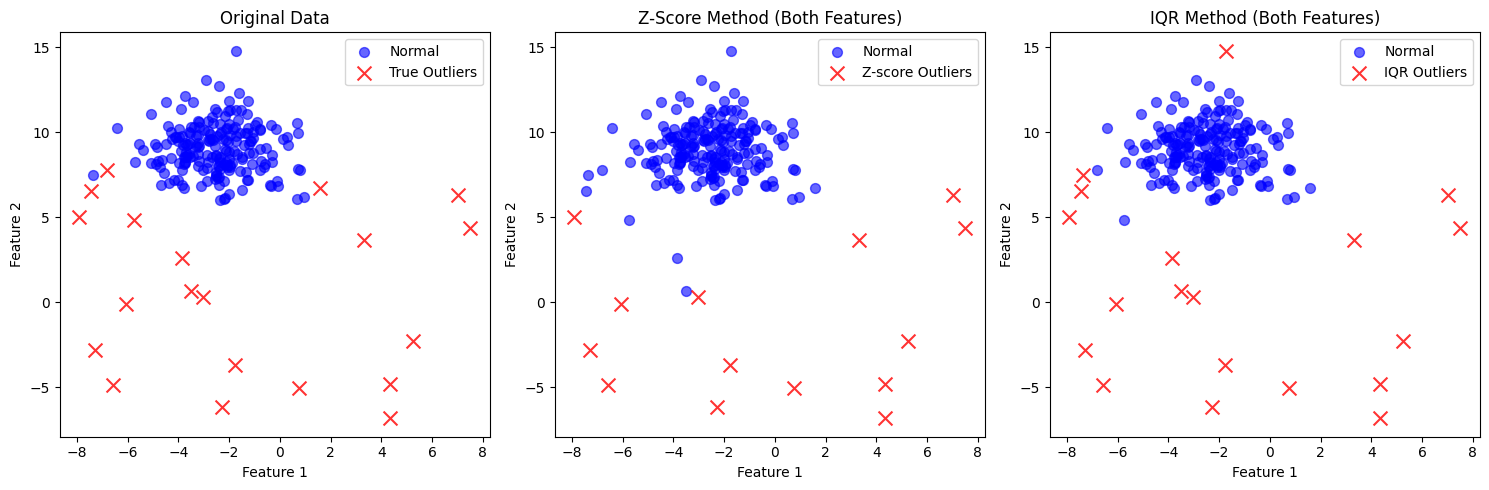

In [ ]:
def z_score_outlier_detection_multivariate(data, threshold=3):
    """
    Detect outliers using z-score method for multivariate data.
    A point is considered an outlier if any of its features' z-scores exceeds the threshold.
    """
    z_scores = np.abs((data - np.mean(data, axis=0)) / np.std(data, axis=0))
    # Outlier if any feature's z-score is above threshold
    return np.any(z_scores > threshold, axis=1)

def iqr_outlier_detection_multivariate(data):
    """
    Detect outliers using the IQR method for multivariate data.
    A point is considered an outlier if any of its features are outside the IQR bounds.
    """
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (data < lower_bound) | (data > upper_bound)
    # Outlier if any feature is marked as outlier
    return np.any(outliers, axis=1)

# Apply statistical methods to both features
features = X  # Shape: (n_samples, 2)

# Z-score method (using both features)
z_outliers_multi = z_score_outlier_detection_multivariate(features, threshold=2.5)

# IQR method (using both features)
iqr_outliers_multi = iqr_outlier_detection_multivariate(features)

print("Statistical Outlier Detection Results (using both features):")
print(f"Z-score method detected {np.sum(z_outliers_multi)} outliers")
print(f"IQR method detected {np.sum(iqr_outliers_multi)} outliers")
print(f"True outliers in dataset: {np.sum(y==1)}")

# Visualize the results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Original data
axes[0].scatter(X[y == 0, 0], X[y == 0, 1], c='blue', alpha=0.6, label='Normal', s=50)
axes[0].scatter(X[y == 1, 0], X[y == 1, 1], c='red', alpha=0.8, label='True Outliers', s=100, marker='x')
axes[0].set_title('Original Data')
axes[0].legend()
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')

# Z-score outliers (multivariate)
axes[1].scatter(X[~z_outliers_multi, 0], X[~z_outliers_multi, 1], c='blue', alpha=0.6, label='Normal', s=50)
axes[1].scatter(X[z_outliers_multi, 0], X[z_outliers_multi, 1], c='red', alpha=0.8, label='Z-score Outliers', s=100, marker='x')
axes[1].set_title('Z-Score Method (Both Features)')
axes[1].legend()
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')

# IQR outliers (multivariate)
axes[2].scatter(X[~iqr_outliers_multi, 0], X[~iqr_outliers_multi, 1], c='blue', alpha=0.6, label='Normal', s=50)
axes[2].scatter(X[iqr_outliers_multi, 0], X[iqr_outliers_multi, 1], c='red', alpha=0.8, label='IQR Outliers', s=100, marker='x')
axes[2].set_title('IQR Method (Both Features)')
axes[2].legend()
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')

plt.tight_layout()
plt.show()

## 3. Методи на основі відстані

Методи на основі відстані ідентифікують викиди, вимірюючи відстань між точками даних. Ключове припущення полягає в тому, що викиди знаходяться далеко від більшості інших точок у наборі даних.

### Відстань k-найближчих сусідів (k-NN)

Метод відстані k-NN обчислює відстань до k-го найближчого сусіда для кожної точки. Точки з великими відстанями k-NN вважаються викидами.

**Алгоритм:**
1. Для кожної точки даних знайти її k найближчих сусідів
2. Обчислити відстань до k-го найближчого сусіда
3. Точки з відстанями вище порогу є викидами

**Переваги:**
- Добре працює з багатовимірними даними
- Непараметричний (немає припущень про розподіл)
- Може виявляти викиди у будь-якій формі даних

**Недоліки:**
- Чутливий до вибору k
- Обчислювально дорогий для великих наборів даних
- Може не працювати добре з високовимірними даними

k-NN Distance Method Results:
k-NN method detected 22 outliers
Threshold distance: 1.653


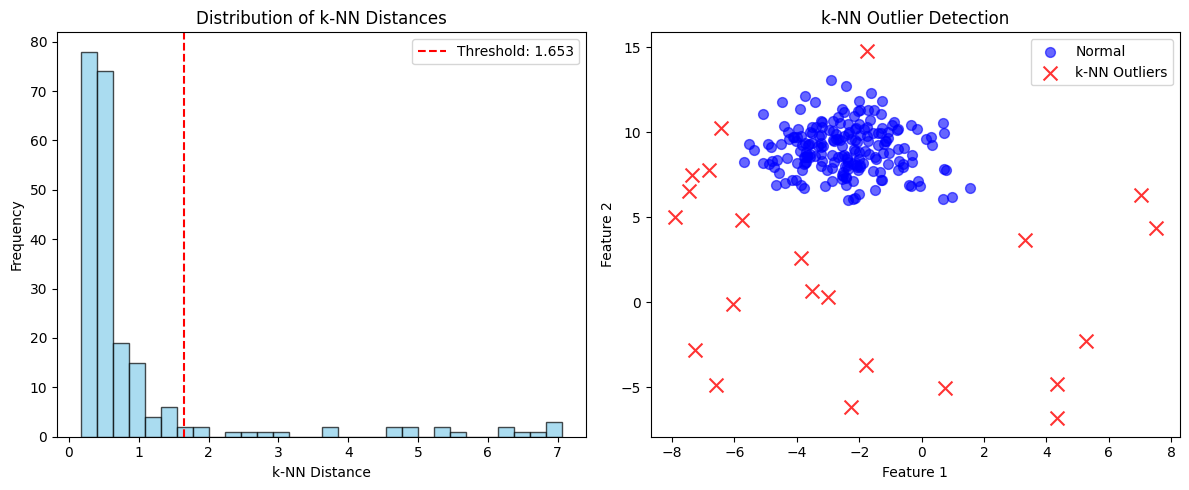


Comparison with true outliers:
True outliers: 20
k-NN detected: 22
Overlap: 19


In [7]:
from sklearn.neighbors import NearestNeighbors

def knn_outlier_detection(X, k=5, threshold_percentile=95):
    """
    Detect outliers using k-NN distance method
    
    Parameters:
    - X: input data
    - k: number of nearest neighbors
    - threshold_percentile: percentile to use as threshold
    """
    # Fit k-NN model
    nbrs = NearestNeighbors(n_neighbors=k+1)  # +1 because point is its own neighbor
    nbrs.fit(X)
    
    # Calculate distances to k-th nearest neighbor
    distances, indices = nbrs.kneighbors(X)
    kth_distances = distances[:, k]  # Distance to k-th nearest neighbor
    
    # Set threshold based on percentile
    threshold = np.percentile(kth_distances, threshold_percentile)
    
    # Identify outliers
    outliers = kth_distances > threshold
    
    return outliers, kth_distances, threshold

# Apply k-NN method
knn_outliers, knn_distances, knn_threshold = knn_outlier_detection(X, k=5, threshold_percentile=90)

print("k-NN Distance Method Results:")
print(f"k-NN method detected {np.sum(knn_outliers)} outliers")
print(f"Threshold distance: {knn_threshold:.3f}")

# Visualize k-NN distances
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(knn_distances, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(knn_threshold, color='red', linestyle='--', label=f'Threshold: {knn_threshold:.3f}')
plt.xlabel('k-NN Distance')
plt.ylabel('Frequency')
plt.title('Distribution of k-NN Distances')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X[~knn_outliers, 0], X[~knn_outliers, 1], c='blue', alpha=0.6, label='Normal', s=50)
plt.scatter(X[knn_outliers, 0], X[knn_outliers, 1], c='red', alpha=0.8, label='k-NN Outliers', s=100, marker='x')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('k-NN Outlier Detection')
plt.legend()

plt.tight_layout()
plt.show()

# Compare with true outliers
print(f"\nComparison with true outliers:")
print(f"True outliers: {np.sum(y==1)}")
print(f"k-NN detected: {np.sum(knn_outliers)}")
print(f"Overlap: {np.sum(knn_outliers & (y==1))}")


## 4. Методи на основі щільності

Методи на основі щільності ідентифікують викиди, порівнюючи локальну щільність точки з щільністю її сусідів. Ключова ідея полягає в тому, що викиди мають значно нижчу щільність, ніж їх сусіди.

### Локальний фактор викидів (Local outlier factor, LOF)

**Локальний фактор викидів (LOF)** - один з найпопулярніших методів виявлення викидів на основі щільності.

**Ключові концепції:**

1. **k-відстань**: Відстань до k-го найближчого сусіда
2. **Відстань досяжності**: 
   $$RD_k(A,B) = \max\{k\text{-відстань}(B), d(A,B)\}$$
3. **Локальна щільність досяжності (LRD)**:
   $$LRD_k(A) = \frac{1}{\frac{\sum_{B \in N_k(A)} RD_k(A,B)}{|N_k(A)|}}$$
4. **Локальний фактор викидів**:
   $$LOF_k(A) = \frac{\sum_{B \in N_k(A)} \frac{LRD_k(B)}{LRD_k(A)}}{|N_k(A)|}$$

**Інтерпретація:**
- LOF ≈ 1: Точка має подібну щільність до своїх сусідів (нормальна)
- LOF > 1: Точка має нижчу щільність, ніж її сусіди (викид)
- LOF >> 1: Сильний викид

**Вибір k для LOF:**
- Занадто малий: Може не захопити локальну щільність правильно
- Занадто великий: Може пропустити локальні викиди

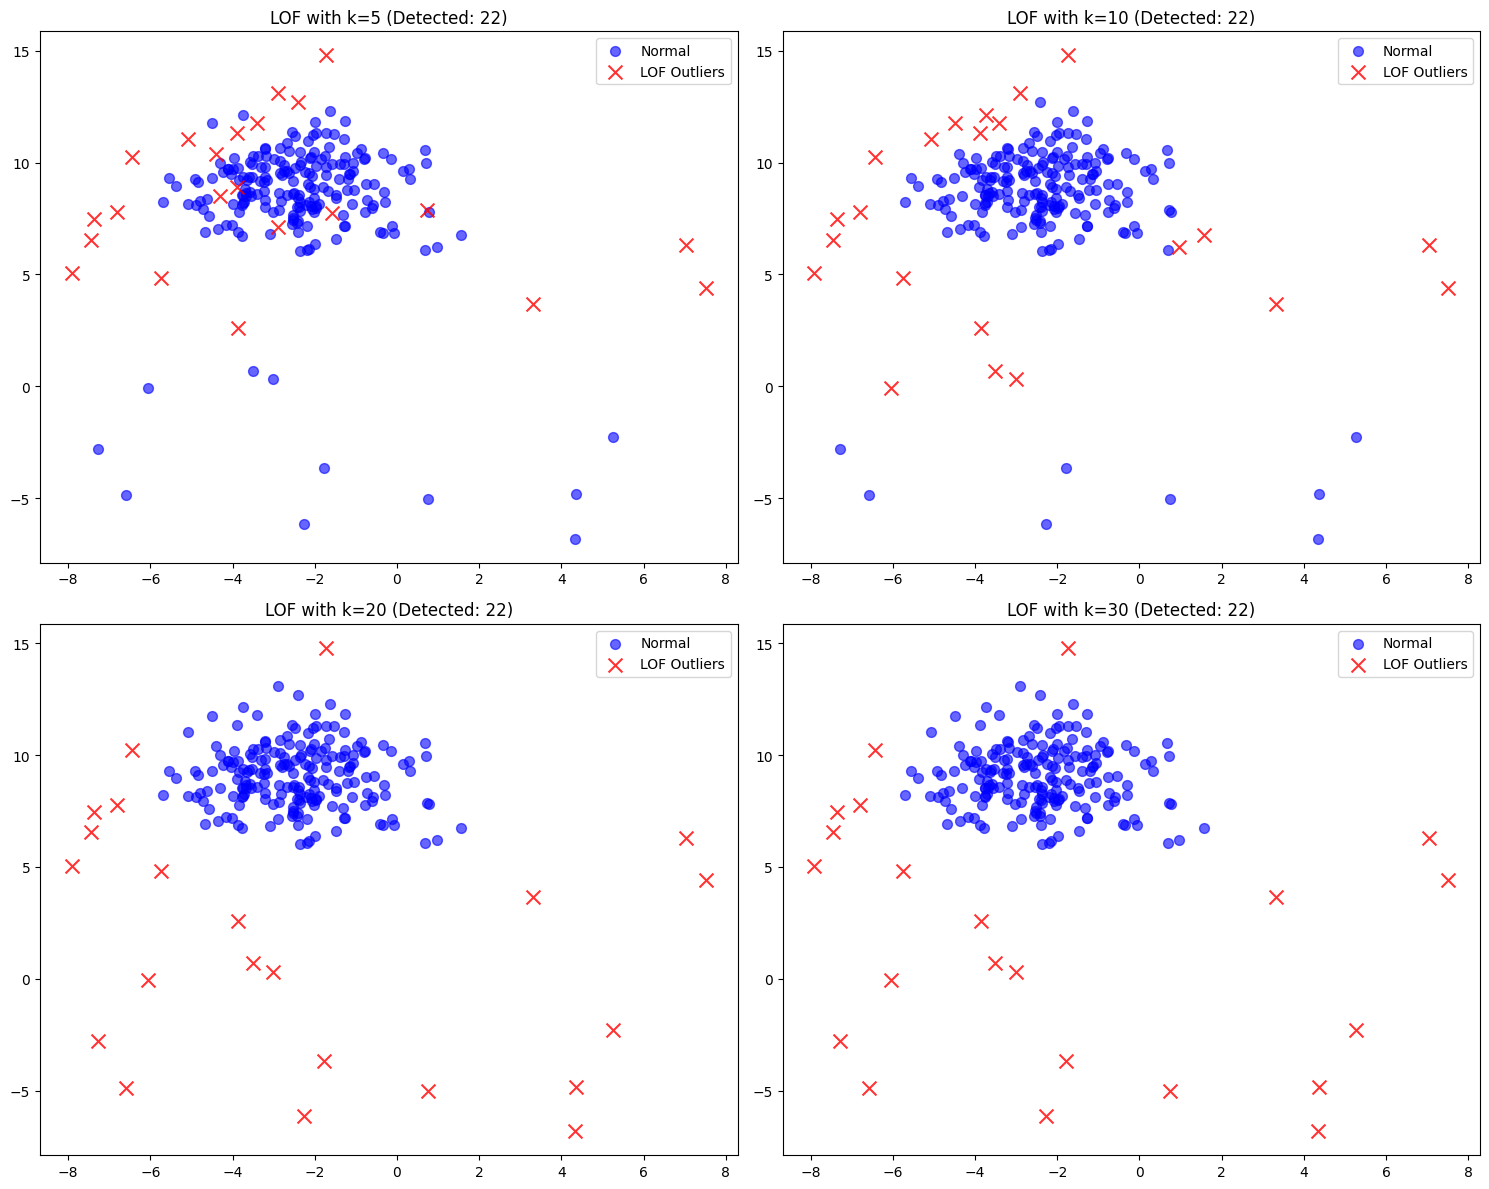

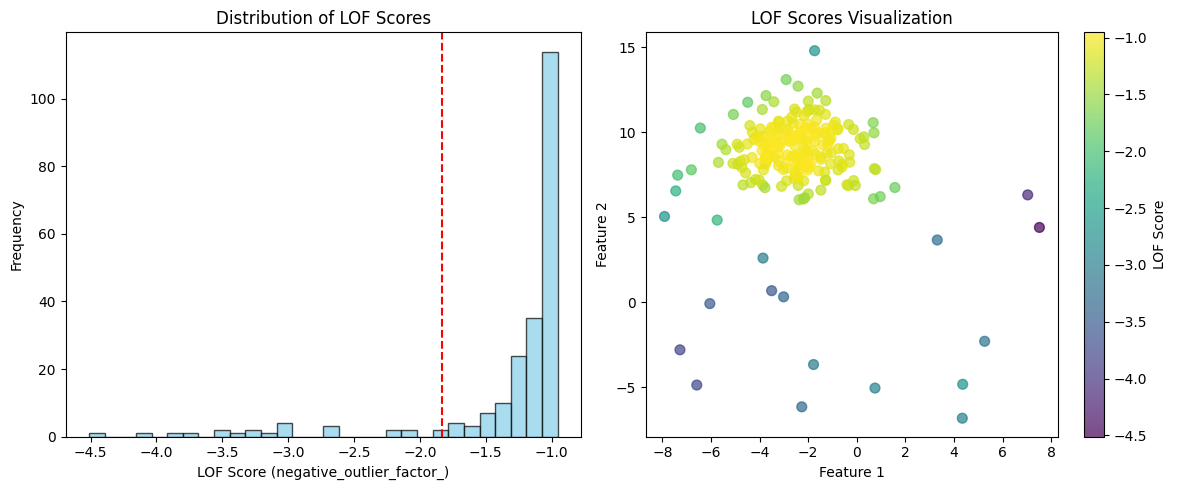

LOF Method Results:
LOF method detected 22 outliers
True outliers: 20
Overlap: 19


In [ ]:
def lof_outlier_detection(X, k=20, contamination=0.1):
    """
    Detect outliers using Local Outlier Factor (LOF)
    
    Parameters:
    - X: input data
    - k: number of neighbors to consider
    - contamination: expected proportion of outliers
    """
    # Fit LOF model
    lof = LocalOutlierFactor(n_neighbors=k, contamination=contamination)
    outlier_labels = lof.fit_predict(X)
    lof_scores = lof.negative_outlier_factor_
    
    # Convert to boolean (True = outlier)
    outliers = outlier_labels == -1
    
    return outliers, lof_scores

# Apply LOF method with different k values
k_values = [5, 10, 20, 30]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, k in enumerate(k_values):
    lof_outliers, lof_scores = lof_outlier_detection(X, k=k, contamination=0.1)
    
    axes[i].scatter(X[~lof_outliers, 0], X[~lof_outliers, 1], c='blue', alpha=0.6, label='Normal', s=50)
    axes[i].scatter(X[lof_outliers, 0], X[lof_outliers, 1], c='red', alpha=0.8, label='LOF Outliers', s=100, marker='x')
    axes[i].set_title(f'LOF with k={k} (Detected: {np.sum(lof_outliers)})')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Analyze LOF scores
lof_outliers_final, lof_scores_final = lof_outlier_detection(X, k=20, contamination=0.1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(lof_scores_final, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('LOF Score (negative_outlier_factor_)')
plt.ylabel('Frequency')
plt.title('Distribution of LOF Scores')
plt.axvline(np.percentile(lof_scores_final, 10), color='red', linestyle='--', label='10th percentile')

plt.subplot(1, 2, 2)
# Plot LOF scores as colors
scatter = plt.scatter(X[:, 0], X[:, 1], c=lof_scores_final, cmap='viridis', s=50, alpha=0.7)
plt.colorbar(scatter, label='LOF Score')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('LOF Scores Visualization')

plt.tight_layout()
plt.show()

print("LOF Method Results:")
print(f"LOF method detected {np.sum(lof_outliers_final)} outliers")
print(f"True outliers: {np.sum(y==1)}")
print(f"Overlap: {np.sum(lof_outliers_final & (y==1))}")

## 5. Ізоляційний ліс

**Ізоляційний ліс** - це алгоритм виявлення аномалій на основі ансамблю, який працює шляхом ізоляції викидів, а не профілювання нормальних точок.

### Як працює ізоляційний ліс

1. **Випадкове розбиття**: Створює випадкові розбиття даних, використовуючи випадкові ознаки та значення розбиття
2. **Дерева ізоляції**: Будує множину дерев ізоляції (iTrees) з випадковими розбиттями
3. **Довжина шляху**: Вимірює, скільки розбиттів потрібно для ізоляції точки
4. **Оцінка аномалії**: Точки, що вимагають менше розбиттів для ізоляції, більш ймовірно є викидами

### Ключові переваги

- **Ефективний**: Добре працює з високовимірними даними
- **Без вчителя**: Не потрібні розмічені навчальні дані
- **Масштабований**: Може обробляти великі набори даних
- **Стійкий**: Менш чутливий до вибору параметрів

### Формула оцінки аномалії

Оцінка аномалії обчислюється як:

$$s(x,n) = 2^{-\frac{E(h(x))}{c(n)}}$$

Де:
- $E(h(x))$ - середня довжина шляху по всіх деревах
- $c(n)$ - середня довжина шляху невдалого пошуку в BST
- $s(x,n) \approx 1$ вказує на аномалії
- $s(x,n) \ll 1$ вказує на нормальні точки

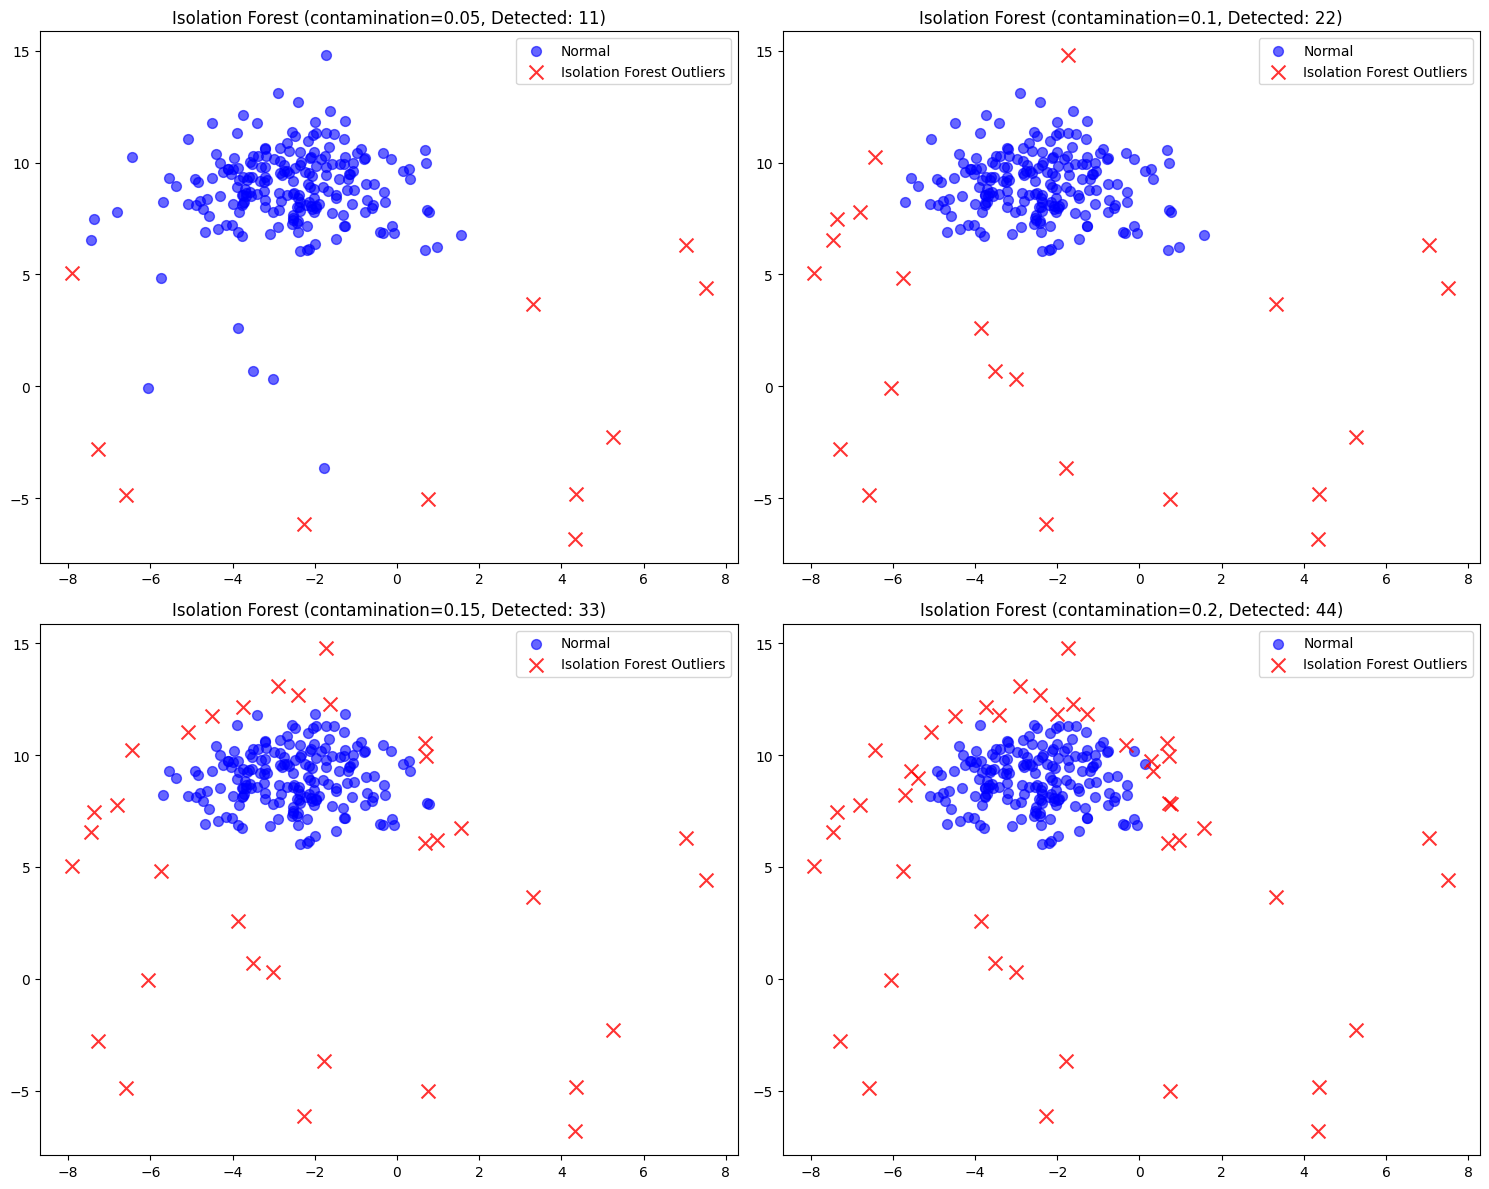

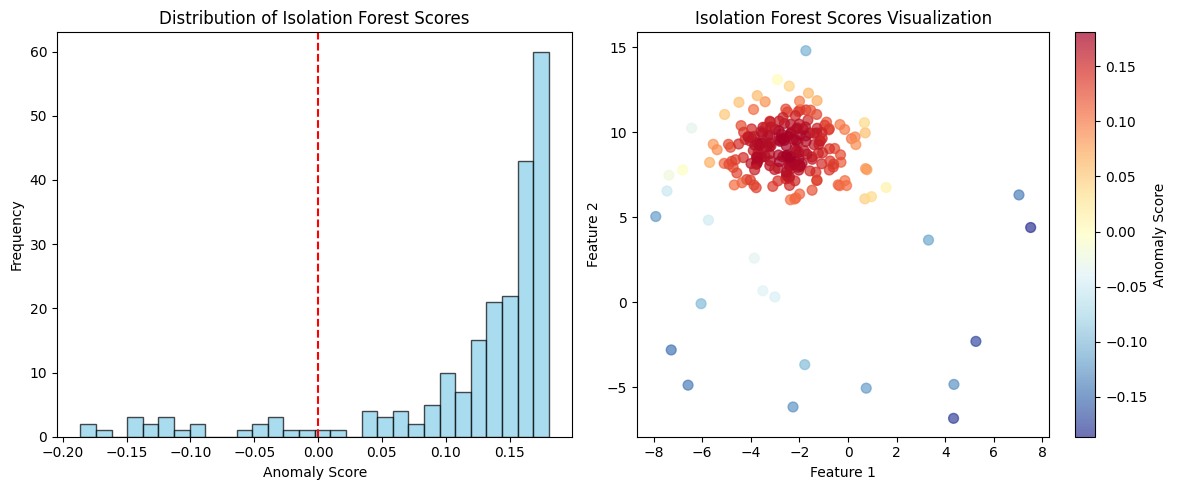

Isolation Forest Results:
Isolation Forest detected 22 outliers
True outliers: 20
Overlap: 19

Method Comparison:
True outliers: 20
k-NN method: 22
LOF method: 22
Isolation Forest: 22


In [9]:
def isolation_forest_detection(X, contamination=0.1, n_estimators=100):
    """
    Detect outliers using Isolation Forest
    
    Parameters:
    - X: input data
    - contamination: expected proportion of outliers
    - n_estimators: number of isolation trees
    """
    # Fit Isolation Forest model
    iso_forest = IsolationForest(contamination=contamination, 
                                n_estimators=n_estimators, 
                                random_state=42)
    outlier_labels = iso_forest.fit_predict(X)
    anomaly_scores = iso_forest.decision_function(X)
    
    # Convert to boolean (True = outlier)
    outliers = outlier_labels == -1
    
    return outliers, anomaly_scores

# Apply Isolation Forest with different parameters
contamination_values = [0.05, 0.1, 0.15, 0.2]
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, contamination in enumerate(contamination_values):
    iso_outliers, iso_scores = isolation_forest_detection(X, contamination=contamination)
    
    axes[i].scatter(X[~iso_outliers, 0], X[~iso_outliers, 1], c='blue', alpha=0.6, label='Normal', s=50)
    axes[i].scatter(X[iso_outliers, 0], X[iso_outliers, 1], c='red', alpha=0.8, label='Isolation Forest Outliers', s=100, marker='x')
    axes[i].set_title(f'Isolation Forest (contamination={contamination}, Detected: {np.sum(iso_outliers)})')
    axes[i].legend()

plt.tight_layout()
plt.show()

# Analyze Isolation Forest scores
iso_outliers_final, iso_scores_final = isolation_forest_detection(X, contamination=0.1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(iso_scores_final, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Isolation Forest Scores')
plt.axvline(0, color='red', linestyle='--', label='Decision boundary (0)')

plt.subplot(1, 2, 2)
# Plot anomaly scores as colors
scatter = plt.scatter(X[:, 0], X[:, 1], c=iso_scores_final, cmap='RdYlBu_r', s=50, alpha=0.7)
plt.colorbar(scatter, label='Anomaly Score')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Isolation Forest Scores Visualization')

plt.tight_layout()
plt.show()

print("Isolation Forest Results:")
print(f"Isolation Forest detected {np.sum(iso_outliers_final)} outliers")
print(f"True outliers: {np.sum(y==1)}")
print(f"Overlap: {np.sum(iso_outliers_final & (y==1))}")

# Compare different methods
print(f"\nMethod Comparison:")
print(f"True outliers: {np.sum(y==1)}")
print(f"k-NN method: {np.sum(knn_outliers)}")
print(f"LOF method: {np.sum(lof_outliers_final)}")
print(f"Isolation Forest: {np.sum(iso_outliers_final)}")
